In [1]:
import sys
sys.path.append("../../")

In [103]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask
from functions.floodmodels import reshape_scalar_predictand, shift_input
import xarray as xr
#Creating a Dask local cluster for parallel computing (making the computations later on much faster)
from dask.distributed import Client, LocalCluster


In [3]:
#HYPERPARAMETERS
days_intake_length = 90
forecast_day = 30


#LIBRARY IMPORTS
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
#cluster = LocalCluster()  # n_workers=10, threads_per_worker=1,
client = Client(processes=False)


/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
#This will tell you where you dashboard will be so you can visualize your model being run
print(client.scheduler_info()['services'])

{'dashboard': 53284}


In [5]:
#Loading the transformed dataset
glofas_loaded = xr.open_mfdataset("/Volumes/portableHardDisk/data/glofas_region/Danube/glofas_masked_danube_*.nc")

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [6]:
era5_loaded = xr.open_mfdataset("/Volumes/portableHardDisk/data/Elbe/reanalysis-era5-single-levels_convective_precipitation,land_sea_mask,large_scale_precipitation,runoff,slope_of_sub_gridscale_orography,soil_type,total_column_water_vapour,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2_*.nc", combine="by_coords")

In [11]:
y_orig = glofas_loaded
#Making a copy because y will be transformed to represent the variation of discharge. The model will be predicting the variation of discharge, not the quantity of discharge itself
y = y_orig

In [87]:
period_train = dict(time=slice(None, '2012'))
period_test = dict(time=slice('2013', '2016'))
entire_period = dict(time=slice(None, '2018'))

In [8]:
danube_basin_mask = get_basin_mask(glofas_loaded['dis24'].isel(time=0), 'Danube')

In [12]:
#Reshape to align in coordinates
era5_masked = era5_loaded.interp(latitude=y.latitude, longitude=y.longitude).where(danube_basin_mask, drop=True)
X = era5_masked


#Downsampling our time from hourly to daily
X = X.resample(time='1D').mean()


In [26]:
y.isel(latitude=55, longitude=130)['dis24']

<xarray.DataArray 'dis24' (time: 7610)>
dask.array<getitem, shape=(7610,), dtype=float32, chunksize=(5114,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 44.95
    longitude  float64 21.05
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-11-01
Attributes:
    long_name:  mean discharge in the last 24 hours
    units:      m3/s

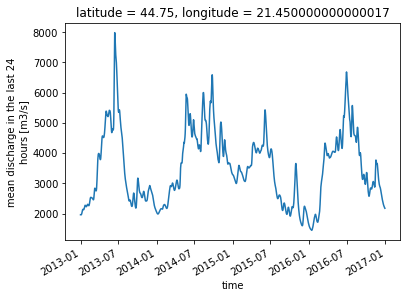

In [72]:
y.loc[period_test].isel(latitude=57, longitude=134)['dis24'].plot()

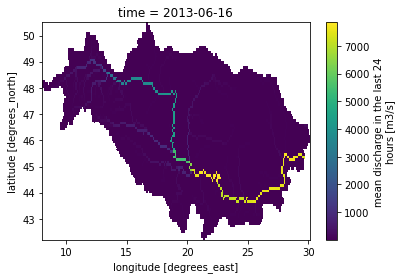

In [62]:
y['dis24'].isel(time=5280).plot()

In [90]:
X_point = X.isel(latitude=57, longitude=134)

In [91]:
y_point = y.isel(latitude=57, longitude=134)

In [92]:
X_point = X_point.drop(['latitude','longitude'])
y_point = y_point.drop(['latitude','longitude'])

In [93]:
X_point = X_point.loc[entire_period]
y_point = y_point.loc[entire_period]

In [ ]:
X_point['cp'].values

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [94]:
Xda = X_point.to_array(dim='features').T

In [95]:
Xda.shape

(7305, 9)

In [96]:
yda = y_point['dis24']

In [97]:
yda

<xarray.DataArray 'dis24' (time: 7305)>
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(5114,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2018-12-31
Attributes:
    long_name:  mean discharge in the last 24 hours
    units:      m3/s

In [99]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [100]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [120]:
Xda.values

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [104]:
X_train_final, y_train_final = shift_input(X_train_scaled, y_train_scaled, days_intake_length, 1)

In [108]:
y_train_final = y_train_final.reshape(-1)

In [112]:
#LSTM MODEL
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences= True, input_shape=(X_train_final.shape[1], X_train_final.shape[2]))) #(n_timesteps, n_features)#(n_sample, n_timesteps, n_features)
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

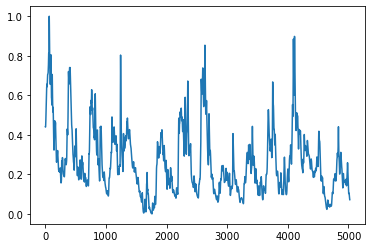

In [116]:
plt.plot(y_train_final)

In [113]:
training_history = regressor.fit(X_train_final, y_train_final, epochs=100, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2112/5023 [===========>..................] - ETA: 24s - loss: nan

KeyboardInterrupt: 

In [ ]:
#SAVING THE MODEL
# serialize model to YML
regressor_yaml = regressor.to_yaml()
with open("./danube_model.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("./danube_model.h5")
#Seialize feature scaling weights